In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U albumentations

     |████████████████████████████████| 81kB 6.2MB/s 
     |████████████████████████████████| 952kB 14.9MB/s 
     |████████████████████████████████| 38.2MB 70kB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
from torchvision import transforms
import numpy as np
from torch import optim 
from torch.utils.data import DataLoader
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch.transforms import ToTensor
import cv2
from PIL import Image

In [4]:
import sys
sys.path.append('/content/drive/MyDrive/utils')

In [5]:
import dataset
import loss_fn
import model
import IOU
import convert
import NMS
import mAP

In [64]:
video_path = '/content/drive/MyDrive/archive/traffic-sign-to-test.mp4'
vid = cv2.VideoCapture(video_path)
out_stream = '/content/drive/MyDrive/test.mp4'

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(out_stream, fourcc, 10.0, (448,  448), True)

length = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))

for i in range(length):
  ret, frame = vid.read()
  # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  new_frame = __predict__(frame, device, my_model)
  
  if ret == True:
    out.write((new_frame * 255).astype('uint8'))

In [65]:
out.release()

In [6]:
def get_bboxes(loader, model, iou_threshold, threshold, pred_format="cells", box_format="midpoint", device="cuda"):
    all_pred_boxes = []
    all_true_boxes = []
    
    model.eval()
    train_idx = 0

    for x, labels in tqdm(loader):
      x = x.to(device)
      labels = labels.to(device)

      with torch.no_grad():
          predictions = model(x)

      batch_size = x.shape[0]
      true_bboxes = convert.cellboxes_to_boxes(labels)
      pred_bboxes = convert.cellboxes_to_boxes(predictions)

      for idx in range(batch_size):
        pred_nms_boxes = NMS.non_max_suppression(
            pred_bboxes[idx],
            iou_threshold=iou_threshold,
            threshold=threshold,
            box_format=box_format,
        )

        target_nms_boxes = NMS.non_max_suppression(
            true_bboxes[idx],
            iou_threshold=iou_threshold,
            threshold=threshold,
            box_format=box_format,
        )

        for nms_box in pred_nms_boxes:
           all_pred_boxes.append(np.insert(nms_box, 0, train_idx))

        for box in target_nms_boxes:
          all_true_boxes.append(np.insert(box, 0, train_idx))

        train_idx += 1

    return all_pred_boxes, all_true_boxes

In [7]:
def save_checkpoint(state, filename='/content/drive/MyDrive/checkpoint_1.pth.tar'):
  torch.save(state, filename)

def load_check_point(device, PATH='/content/drive/MyDrive/checkpoint_1.pth.tar'):
  my_model = model.YOLOV1(grid=7, num_boxes=2, num_classes=4).to(device)
  optimizer = optim.Adam(my_model.parameters(), lr=0, weight_decay=0)
  checkpoint = torch.load(PATH, map_location=device)
  my_model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  # loss = checkpoint['loss']
  test_m_ap = checkpoint['test_mAP']
  train_m_ap = checkpoint['train_mAP']
  return my_model, optimizer, test_m_ap, train_m_ap

In [8]:
device = torch.device('cuda')
my_model, optimizer, test_m_ap, train_m_ap = load_check_point(device)

In [9]:
print(train_m_ap, test_m_ap)

tensor(0.8116, device='cuda:0') tensor(0.7009, device='cuda:0')


In [10]:
training_transform = A.Compose([
                                A.Resize(448, 448),
                                A.HorizontalFlip(),
                                A.Rotate(45),
                                A.RandomRotate90(),
                                ToTensor()

], bbox_params=A.BboxParams(format='yolo', label_fields=[]))

valid_transform = A.Compose([
                             A.Resize(448, 448),
                             ToTensor()
], bbox_params=A.BboxParams(format='yolo', label_fields=[]))

In [11]:
categories = {0: 'prohibitory',
              1: 'danger',
              2: 'mandatory',
              3: 'other'}
color = [(255,0,0), (255,255,0), (0,0,255), (255,255,255)]

In [60]:
def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    thickness = 2
    font = cv2.FONT_HERSHEY_SIMPLEX

    for box in boxes:
        label = int(box[0])

        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2

        pt1 = (int(upper_left_x * width), int(upper_left_y * height))
        pt2 = (int(upper_left_x * width + box[2] * width), int(upper_left_y * height + box[3] * height))

        image = cv2.rectangle(image, pt1, pt2, color[label], thickness)
        image = cv2.putText(image, categories[label], pt1, font, 1, color[label], thickness)
        
    return image


In [13]:
def train_fn(train_loader, model, optimizer, loss_func):
  mean_loss = []
  if model.training == False:
    model.train()
  
  for img, mt in tqdm(train_loader):
      img, mt = img.to(device), mt.to(device)
      preds = my_model(img)
      loss = loss_func(preds, mt)
      mean_loss.append(loss.item())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  print(f"Mean loss: {sum(mean_loss)/len(mean_loss)}")

In [14]:
def change_lr(optimizer, lr):
  print('Changing learning rate .....')
  for g in optimizer.param_groups:
    g['lr'] = lr

In [15]:
loss_func = loss_fn.Yolo_Loss()

batch_size = 17
learning_rate = 1e-6
weight_decay = 0.005
# optimizer = optim.Adam(my_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [16]:
train_path = '/content/drive/MyDrive/archive/train.txt'
test_path = '/content/drive/MyDrive/archive/test.txt'
directory = '/content/drive/MyDrive/archive/ts/'

TrafficDataset_train = dataset.TrafficSign(directory=directory, path=train_path, transform=training_transform)
train_loader = DataLoader(TrafficDataset_train, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=True, drop_last=False)

TrafficDataset_test = dataset.TrafficSign(directory=directory, path=train_path, transform=valid_transform)
test_loader = DataLoader(TrafficDataset_test, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=True, drop_last=False)

TrafficDataset_valid = dataset.TrafficSign(directory=directory, path=test_path, transform=valid_transform)
val_loader = DataLoader(TrafficDataset_valid, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=True, drop_last=False)

In [ ]:
seed = 123
torch.manual_seed(seed)
epochs = 100
for epoch in range(epochs):
  train_fn(train_loader, my_model, optimizer, loss_func)
  # Train set:
  print("Evaluating train set.....")
  pred_boxes, true_boxes = get_bboxes(test_loader, my_model, 0.5, 0.4)
  train_average_precision = mAP.mean_average_precision(pred_boxes, true_boxes)

  # Test set:
  print("Evaluating test set.....")
  pred_boxes_, true_boxes_ = get_bboxes(val_loader, my_model, 0.5, 0.4)
  test_average_precision = mAP.mean_average_precision(pred_boxes_, true_boxes_)

  if test_average_precision.to(device) > m_ap:
      m_ap = test_average_precision
      print("Epoch: ", epoch)
      print(train_average_precision)
      checkpoint = {
          'state_dict': my_model.state_dict(),
          'optimizer': optimizer.state_dict(),
          'epoch': epoch,
          'mAP': test_average_precision
      }
      save_checkpoint(checkpoint)

  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 7.259401711550626
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7750)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6304)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 6.938334513794292
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7845)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.5977)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 7.286370775916359
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7802)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6080)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 7.033545212312178
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7723)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.5927)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 7.437790708108381
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7392)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.5745)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 7.11147560856559
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7438)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.5486)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 6.973787416111339
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7473)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.5790)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 7.625402737747539
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7290)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.4852)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 6.928229852156206
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7619)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6196)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 7.012906995686618
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.8144)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6394)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 7.005040564320304
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7530)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.5956)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 6.7442229119214145
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7829)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6521)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 7.094517057592219
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7535)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.4917)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 7.040294067426161
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7920)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.5584)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 6.622476008805362
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7758)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.5271)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 6.882741353728554
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7032)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6015)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 6.874398990110918
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7836)
Evaluating test set.....


100%|██████████| 3/3 [00:01<00:00,  1.95it/s]


tensor(0.6937)
Epoch:  16
tensor(0.7836)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 7.241506191817197
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7452)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6308)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 7.4139438542452725
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7261)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.5621)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 6.851213054223494
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7849)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.5974)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 7.094954577359286
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7483)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6061)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 6.763247706673362
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.8053)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6009)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 7.069067472761327
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7587)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6048)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 7.012568896467036
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7763)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.5739)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 7.171399008144032
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7012)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.5999)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 6.879903695800087
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7937)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6820)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 7.023232747207988
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7612)
Evaluating test set.....


100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


tensor(0.7115)
Epoch:  26
tensor(0.7612)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 7.114461801268837
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7734)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6309)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 6.689128994941711
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7690)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.5684)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 6.559978311712092
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.8061)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.5597)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 6.7657763957977295
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7610)
Evaluating test set.....


100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


tensor(0.7141)
Epoch:  30
tensor(0.7610)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 6.760533657940951
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7756)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.7069)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 6.943962942470204
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7952)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6138)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 7.184816208752719
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7837)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6618)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 6.861308401281184
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7366)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6483)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 7.110892350023443
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7238)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6861)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 7.415693245150826
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7425)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6327)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 8.392531720074741
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7485)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6300)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 7.881244464354082
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.8128)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6628)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 8.265031955458902
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7004)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6262)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 7.75471550768072
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7175)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6562)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 8.075624650174921
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7101)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6712)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 8.219300898638638
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7329)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6924)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 8.207650607282465
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.6831)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.5803)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 7.805424159223383
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7420)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6532)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 7.790017778223211
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7342)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6801)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 7.626350619576194
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7644)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.7121)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 8.805158734321594
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7387)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.5648)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 9.20879671790383
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7676)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6819)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 11.93159061128443
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7369)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.5888)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 12.75668262351643
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7585)
Evaluating test set.....


100%|██████████| 3/3 [00:01<00:00,  1.85it/s]


tensor(0.7200)
Epoch:  50
tensor(0.7585)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 12.569818594238974
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7855)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6198)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 11.452194408936935
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7432)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6008)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 12.57421414418654
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7760)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6568)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 12.708442005244168
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7568)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6381)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 12.680434855547817
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7373)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6588)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 12.594178806651723
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7525)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.6981)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 12.428613836115057
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7315)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.5557)


  0%|          | 0/44 [00:00<?, ?it/s]

Mean loss: 11.894271503795277
Evaluating train set.....


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.8116)
Evaluating test set.....


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.7009)


 89%|████████▊ | 39/44 [00:22<00:02,  1.81it/s]

KeyboardInterrupt: ignored

In [22]:
itr = iter(val_loader)
my_model.eval()
img, mt = next(itr)

In [23]:
image = img[1].to(device).unsqueeze(0)

with torch.no_grad(): 
  preds = my_model(image)
  bboxes = convert.cellboxes_to_boxes(preds)
  boxes = NMS.non_max_suppression(bboxes[0], 0.5, 0.4)
  a = plot_image(img[1].to('cpu').numpy().transpose(1, 2, 0), boxes)
  # print(img[1].shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


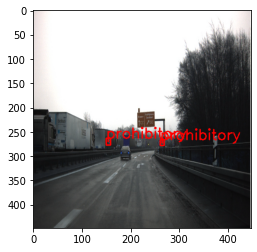

In [24]:
plt.imshow(a)

In [57]:
def __predict__(image, device, model):
  transformed = valid_transform(image=image, bboxes=[]) 
  model.eval()
  with torch.no_grad():
    img = transformed['image'].unsqueeze(0)
    img = img.to(device)
    output = model(img)
    bbox = convert.cellboxes_to_boxes(output)
    boxes = NMS.non_max_suppression(bbox[0], 0.5, 0.4)
    image = plot_image(img.squeeze().to('cpu').numpy().transpose(1, 2, 0), boxes)
  
  return image

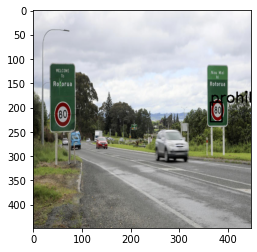

In [62]:
image = cv2.imread('/content/drive/MyDrive/sample_images/images1.jpg')
img = __predict__(image, device, my_model)
plt.imshow((img * 255).astype(np.uint8))